In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import pandas_datareader.data as web
from time import time

### Data Preparation

In [29]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [30]:
base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data

### Standardized Data

In [31]:
#Standardized data (X1, X2, X3) with kept index (date)
scaler = preprocessing.StandardScaler()
X1 = pd.DataFrame(scaler.fit_transform(X1.values),index = X1.index,columns=X1.columns)
X2 = pd.DataFrame(scaler.fit_transform(X2.values),index = X2.index,columns=X2.columns)
X3 = pd.DataFrame(scaler.fit_transform(X3.values),index = X3.index,columns=X3.columns)

In [32]:
X1

Attributes Adj Close          
Symbols        GOOGL       IBM
Date                          
2017-10-06 -1.081086 -0.475712
2017-10-09 -1.083200 -0.412468
2017-10-10 -1.090368 -0.335325
2017-10-11 -1.061996 -0.396483
2017-10-12 -1.061996 -0.437488
...              ...       ...
2022-09-29  0.436464  0.559636
2022-09-30  0.380197  0.299602
2022-10-03  0.475247  0.548571
2022-10-04  0.570614  0.916491
2022-10-05  0.563939  0.938622

[1258 rows x 2 columns]

In [33]:
X2

,DEXJPUS,DEXUSUK
DATE,,
2017-10-09,NaN,NaN
2017-10-10,0.004572,0.199625
2017-10-11,0.028951,0.191501
2017-10-12,0.032608,0.133005
2017-10-13,-0.021025,0.344241
...,...,...
2022-09-26,3.941723,-3.882112
2022-09-27,3.973415,-3.800867
2022-09-28,3.905155,-3.672500


In [34]:
X3

,SP500,DJIA,VIXCLS
DATE,,,
2017-10-09,-1.237223,-1.438114,-1.191203
2017-10-10,-1.228587,-1.421087,-1.220031
2017-10-11,-1.221866,-1.410762,-1.246552
2017-10-12,-1.228164,-1.418560,-1.239633
2017-10-13,-1.224891,-1.411048,-1.274226
...,...,...,...
2022-09-29,0.363808,0.143161,1.289094
2022-09-30,0.283664,0.020833,1.263726
2022-10-03,0.419273,0.208051,1.088456


In [35]:
#Calculate ความแตกต่างของค่า ราคา 'Adj Close', 'MSFT’)ย้อนหลัง backHisotry วัน
return_period = 1
backHistory = [30, 45, 60, 90, 180, 240] 
BH1, BH2, BH3 = backHistory[0], backHistory[1], backHistory[2]
Y = base. shift(-return_period)
X4_BH1 = base.diff( BH1).shift( - BH1)
X4_BH2 = base.diff( BH2).shift( - BH2)
X4_BH3 = base.diff( BH3).shift( - BH3)

In [36]:
X4_BH1

Date
2017-10-06    6.402596
2017-10-09    6.252869
2017-10-10    7.376671
2017-10-11    6.678429
2017-10-12    6.162354
                ...   
2022-09-29         NaN
2022-09-30         NaN
2022-10-03         NaN
2022-10-04         NaN
2022-10-05         NaN
Name: (Adj Close, MSFT), Length: 1258, dtype: float64

In [37]:
X4_BH2

Date
2017-10-06    9.075180
2017-10-09    9.133217
2017-10-10    8.916000
2017-10-11    8.170555
2017-10-12    9.552635
                ...   
2022-09-29         NaN
2022-09-30         NaN
2022-10-03         NaN
2022-10-04         NaN
2022-10-05         NaN
Name: (Adj Close, MSFT), Length: 1258, dtype: float64

In [38]:
X4_BH3

Date
2017-10-06    10.132874
2017-10-09    10.578094
2017-10-10    11.598022
2017-10-11    11.560829
2017-10-12    10.846428
                ...    
2022-09-29          NaN
2022-09-30          NaN
2022-10-03          NaN
2022-10-04          NaN
2022-10-05          NaN
Name: (Adj Close, MSFT), Length: 1258, dtype: float64

In [39]:
X4 = pd.concat([X4_BH1, X4_BH2, X4_BH3], axis=1)
X4

Adj Close                     
                MSFT      MSFT       MSFT
Date                                     
2017-10-06  6.402596  9.075180  10.132874
2017-10-09  6.252869  9.133217  10.578094
2017-10-10  7.376671  8.916000  11.598022
2017-10-11  6.678429  8.170555  11.560829
2017-10-12  6.162354  9.552635  10.846428
...              ...       ...        ...
2022-09-29       NaN       NaN        NaN
2022-09-30       NaN       NaN        NaN
2022-10-03       NaN       NaN        NaN
2022-10-04       NaN       NaN        NaN
2022-10-05       NaN       NaN        NaN

[1258 rows x 3 columns]

In [40]:
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X4 = pd.DataFrame(scaler.fit_transform(X4.values), index = X4.index,columns=X4.columns)
X4

,MSFT_3DT,MSFT_6DT,MSFT_12DT
Date,,,
2017-10-06,0.132147,0.122732,0.042254
2017-10-09,0.122751,0.126019,0.064208
2017-10-10,0.193276,0.113715,0.114499
2017-10-11,0.149457,0.071489,0.112665
2017-10-12,0.117070,0.149777,0.077439
...,...,...,...
2022-09-29,NaN,NaN,NaN
2022-09-30,NaN,NaN,NaN
2022-10-03,NaN,NaN,NaN


In [41]:
X = pd.concat([X1, X2, X3, X4], axis=1)
X

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-06,-1.081086,-0.475712,NaN,NaN,NaN,NaN,NaN,0.132147,0.122732,0.042254
2017-10-09,-1.083200,-0.412468,NaN,NaN,-1.237223,-1.438114,-1.191203,0.122751,0.126019,0.064208
2017-10-10,-1.090368,-0.335325,0.004572,0.199625,-1.228587,-1.421087,-1.220031,0.193276,0.113715,0.114499
2017-10-11,-1.061996,-0.396483,0.028951,0.191501,-1.221866,-1.410762,-1.246552,0.149457,0.071489,0.112665
2017-10-12,-1.061996,-0.437488,0.032608,0.133005,-1.228164,-1.418560,-1.239633,0.117070,0.149777,0.077439
...,...,...,...,...,...,...,...,...,...,...
2022-09-29,0.436464,0.559636,3.941723,-3.321523,0.363808,0.143161,1.289094,NaN,NaN,NaN
2022-09-30,0.380197,0.299602,3.973415,-3.181782,0.283664,0.020833,1.263726,NaN,NaN,NaN
2022-10-03,0.475247,0.548571,NaN,NaN,0.419273,0.208051,1.088456,NaN,NaN,NaN
2022-10-04,0.570614,0.916491,NaN,NaN,0.583651,0.409957,0.969688,NaN,NaN,NaN


In [42]:
dataset = pd.concat([Y, X], axis=1)
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-06,71.685875,-1.081086,-0.475712,NaN,NaN,NaN,NaN,NaN,0.132147,0.122732,0.042254
2017-10-09,71.685875,-1.083200,-0.412468,NaN,NaN,-1.237223,-1.438114,-1.191203,0.122751,0.126019,0.064208
2017-10-10,71.808044,-1.090368,-0.335325,0.004572,0.199625,-1.228587,-1.421087,-1.220031,0.193276,0.113715,0.114499
2017-10-11,72.465790,-1.061996,-0.396483,0.028951,0.191501,-1.221866,-1.410762,-1.246552,0.149457,0.071489,0.112665
2017-10-12,72.813454,-1.061996,-0.437488,0.032608,0.133005,-1.228164,-1.418560,-1.239633,0.117070,0.149777,0.077439
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29,232.899994,0.436464,0.559636,3.941723,-3.321523,0.363808,0.143161,1.289094,NaN,NaN,NaN
2022-09-30,240.740005,0.380197,0.299602,3.973415,-3.181782,0.283664,0.020833,1.263726,NaN,NaN,NaN
2022-10-03,248.880005,0.475247,0.548571,NaN,NaN,0.419273,0.208051,1.088456,NaN,NaN,NaN
2022-10-04,249.199997,0.570614,0.916491,NaN,NaN,0.583651,0.409957,0.969688,NaN,NaN,NaN


### (c) Data Preparation

In [43]:
dataset = dataset.dropna()
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-10,71.808044,-1.090368,-0.335325,0.004572,0.199625,-1.228587,-1.421087,-1.220031,0.193276,0.113715,0.114499
2017-10-11,72.465790,-1.061996,-0.396483,0.028951,0.191501,-1.221866,-1.410762,-1.246552,0.149457,0.071489,0.112665
2017-10-12,72.813454,-1.061996,-0.437488,0.032608,0.133005,-1.228164,-1.418560,-1.239633,0.117070,0.149777,0.077439
2017-10-13,72.963799,-1.058468,-0.432622,-0.021025,0.344241,-1.224891,-1.411048,-1.274226,0.131404,0.104941,0.041669
2017-10-16,72.907410,-1.056116,-0.451387,-0.047842,0.313368,-1.218359,-1.390198,-1.239633,0.181828,0.067003,0.046363
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,267.831482,0.981711,1.918078,2.870282,-1.925738,0.662772,0.586407,0.699864,1.341547,-0.794998,-1.845246
2022-07-07,267.093079,1.115575,2.168501,2.910507,-1.784372,0.746846,0.671254,0.624914,1.132231,-0.582315,-2.179826
2022-07-08,263.949738,1.133711,2.135719,2.931229,-1.716126,0.742112,0.659905,0.458869,0.926288,-0.416434,-1.756833
2022-07-11,253.132690,1.016822,2.183983,3.068968,-1.925738,0.676433,0.619713,0.635291,0.596399,-1.068800,-1.200462


In [44]:
dataset.describe()

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000
mean,179.306327,-0.039790,-0.057729,-0.156457,0.104627,-0.042670,-0.037488,-0.023120,0.041770,0.022056,-0.001314
std,78.069512,1.005307,0.976982,0.713432,0.886767,1.002858,1.006732,1.019788,0.943448,0.984304,1.002448
min,71.808044,-1.093960,-3.293202,-1.169259,-2.600069,-1.686275,-2.457918,-1.328421,-3.925251,-3.758618,-3.330122
25%,104.754070,-0.847010,-0.633582,-0.553089,-0.509235,-0.875685,-0.818487,-0.695951,-0.329484,-0.413506,-0.427048
50%,161.433517,-0.517194,-0.159949,-0.297723,0.058259,-0.438994,-0.418348,-0.251435,0.069741,0.071785,0.054468
75%,247.127377,0.898853,0.637677,0.020723,0.800837,0.847548,0.975690,0.424564,0.479514,0.519385,0.539857
max,340.882812,2.102803,2.355182,3.068968,2.014633,2.053018,1.995829,7.152557,3.026324,2.553509,2.533134


In [45]:
#Y = dataset (1st column)
Y_dataset = dataset.columns[0]
Y_dataset = dataset.iloc[:, 0]
Y_dataset = Y_dataset.reset_index()
Y_dataset = Y_dataset.drop(columns=['index'])
Y_dataset

C:\Users\Cherry Labtop\AppData\Local\Temp\ipykernel_11908\2203598990.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  Y_dataset = Y_dataset.drop(columns=['index'])


,Adj Close
,MSFT
0,71.808044
1,72.465790
2,72.813454
3,72.963799
4,72.907410
...,...
1175,267.831482
1176,267.093079
1177,263.949738


In [46]:
#X = dataset (2nd :last column)
X_dataset = dataset.drop(dataset.columns[0],axis=1)
X_dataset = X_dataset.reset_index()
X_dataset = X_dataset.drop(columns=['index'])
X_dataset

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-1.090368,-0.335325,0.004572,0.199625,-1.228587,-1.421087,-1.220031,0.193276,0.113715,0.114499
1,-1.061996,-0.396483,0.028951,0.191501,-1.221866,-1.410762,-1.246552,0.149457,0.071489,0.112665
2,-1.061996,-0.437488,0.032608,0.133005,-1.228164,-1.418560,-1.239633,0.117070,0.149777,0.077439
3,-1.058468,-0.432622,-0.021025,0.344241,-1.224891,-1.411048,-1.274226,0.131404,0.104941,0.041669
4,-1.056116,-0.451387,-0.047842,0.313368,-1.218359,-1.390198,-1.239633,0.181828,0.067003,0.046363
...,...,...,...,...,...,...,...,...,...,...
1175,0.981711,1.918078,2.870282,-1.925738,0.662772,0.586407,0.699864,1.341547,-0.794998,-1.845246
1176,1.115575,2.168501,2.910507,-1.784372,0.746846,0.671254,0.624914,1.132231,-0.582315,-2.179826
1177,1.133711,2.135719,2.931229,-1.716126,0.742112,0.659905,0.458869,0.926288,-0.416434,-1.756833
1178,1.016822,2.183983,3.068968,-1.925738,0.676433,0.619713,0.635291,0.596399,-1.068800,-1.200462


<AxesSubplot:>

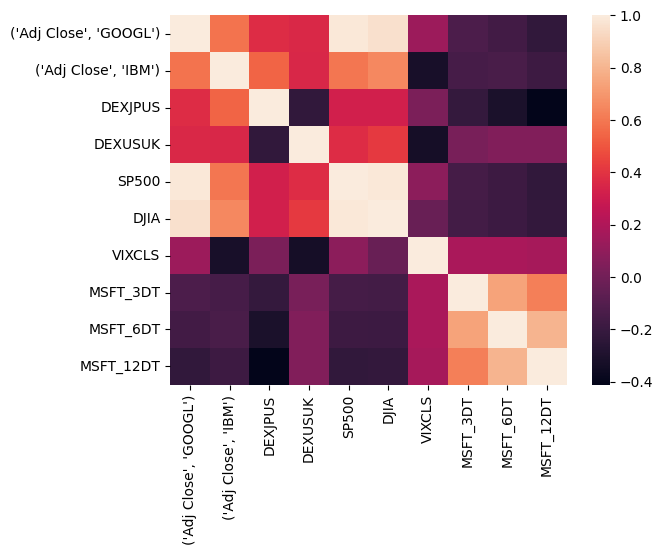

In [47]:
data_corr = X_dataset.corr()
sns.heatmap(data_corr)

In [48]:
lower = pd.DataFrame(np.tril(data_corr, -1),columns = X_dataset.columns)
lower

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.585403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.374333,0.537053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.356125,0.352043,-0.224765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.985032,0.592738,0.319111,0.372869,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.959231,0.650815,0.319001,0.419861,0.985827,0.000000,0.000000,0.000000,0.000000,0.0
6,0.134686,-0.318849,0.033588,-0.329525,0.086897,-0.033976,0.000000,0.000000,0.000000,0.0
7,-0.128491,-0.150068,-0.215437,0.018486,-0.155865,-0.160634,0.179720,0.000000,0.000000,0.0
8,-0.168997,-0.138967,-0.309372,0.046775,-0.184410,-0.186111,0.180650,0.737875,0.000000,0.0
9,-0.226071,-0.185313,-0.412146,0.048857,-0.225731,-0.219235,0.170928,0.620153,0.799811,0.0


In [49]:
#remove ถ้า >0.9
to_drop = [column for column in lower if any(lower[column] > 0.9)]
X_dataset.drop(to_drop, inplace=True, axis=1)
X_dataset

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-0.335325,0.004572,0.199625,-1.421087,-1.220031,0.193276,0.113715,0.114499
1,-0.396483,0.028951,0.191501,-1.410762,-1.246552,0.149457,0.071489,0.112665
2,-0.437488,0.032608,0.133005,-1.418560,-1.239633,0.117070,0.149777,0.077439
3,-0.432622,-0.021025,0.344241,-1.411048,-1.274226,0.131404,0.104941,0.041669
4,-0.451387,-0.047842,0.313368,-1.390198,-1.239633,0.181828,0.067003,0.046363
...,...,...,...,...,...,...,...,...
1175,1.918078,2.870282,-1.925738,0.586407,0.699864,1.341547,-0.794998,-1.845246
1176,2.168501,2.910507,-1.784372,0.671254,0.624914,1.132231,-0.582315,-2.179826
1177,2.135719,2.931229,-1.716126,0.659905,0.458869,0.926288,-0.416434,-1.756833
1178,2.183983,3.068968,-1.925738,0.619713,0.635291,0.596399,-1.068800,-1.200462


In [50]:
# Train / Test Preparation
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_dataset, Y_dataset, test_size=0.3, random_state=0)

In [51]:
X_train

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
634,-0.901106,-0.630491,-0.796436,-1.050497,1.555457,0.285734,1.384939,0.757720
1006,-0.101464,0.154501,1.156689,1.734302,-0.476288,0.901404,0.227287,-2.185117
686,-0.971838,-0.632929,-0.822434,-0.433014,0.818633,0.569766,-0.648966,-0.310003
492,0.136192,-0.652432,-1.140913,-0.596671,-0.177637,0.448631,0.488515,0.589254
1010,0.006732,0.237389,0.921079,1.838774,-0.641179,-0.799005,-1.480311,-1.555232
...,...,...,...,...,...,...,...,...
1033,0.280661,0.209353,0.233748,1.740239,-0.087696,-2.697534,-2.638503,-3.175457
763,-1.550147,-0.927911,-0.068482,-0.283821,1.716890,0.558198,0.374881,1.182683
835,-0.552553,-0.756041,1.647407,0.812469,0.078349,0.889241,0.613318,0.151240
559,-0.153074,-0.266030,-0.177350,0.065239,-0.961739,0.180328,-1.633702,-0.346771


In [52]:
X_test

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
1099,0.774086,0.776157,0.006263,1.326448,0.692946,-0.567052,-2.684343,-2.460799
351,-0.354445,-0.049061,0.306868,-0.716798,-0.825674,0.656739,0.371292,0.422779
704,-0.517212,-0.763355,-0.016486,-0.207648,0.169443,-0.289873,0.449872,-0.521242
434,0.064587,-0.501284,-0.876055,-0.320023,-0.953667,-0.577521,-0.507410,-0.520579
513,-0.194366,-0.433024,-0.302467,-0.288204,-0.902931,0.380725,0.604378,0.800678
...,...,...,...,...,...,...,...,...
561,-0.151535,-0.264812,-0.100980,0.095367,-0.950208,-0.314167,-1.797076,-0.323647
54,0.156706,0.089898,0.581476,-0.930201,-1.208500,-0.067562,0.038670,-0.263194
1005,-0.157658,0.199602,1.051070,1.675648,-0.424399,0.386262,0.381928,-1.741382
526,-0.326840,-0.419616,-0.427584,-0.187056,-0.959432,0.372763,0.889329,0.960163


In [53]:
Y_train

,Adj Close
,MSFT
634,170.657028
1006,328.865723
686,199.904343
492,134.199615
1010,333.645691
...,...
1033,330.937775
763,212.641586
835,226.132065


In [54]:
Y_test

,Adj Close
,MSFT
1099,293.910156
351,111.832298
704,199.374985
434,134.509537
513,140.359680
...,...
561,162.002823
54,80.781303
1005,321.656128


### Create Model List and Parameter Dictionary